# Quickstart

This notebook is intended to demonstrate the basic usage of `superscreen` by calculating the magnetic response of several simple single-layer and multi-layer devices.

In [1]:
# Automatically install superscreen from GitHub only if running in Google Colab
if "google.colab" in str(get_ipython()):
    %pip install --quiet git+https://github.com/loganbvh/superscreen.git

In [2]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["font.size"] = 10

import superscreen as sc
from superscreen.geometry import circle, box

In [3]:
sc.version_table()

## Device geometry and materials

- **Layers** represent different physical planes in a device. All superconducting films in a given layer
  are assumed to have the same thickness and penetration depth.
- **Films** represent the actual superconducting films, each of which exists in a `Layer` and may have one or more holes. Each film can have an arbitrary polygonal geometry, and there can be multiple (non-overlapping) films per layer.
- **Holes** are polygonal regions of vacuum completely surrounded (in 2D) by a superconducting film, which can contain   trapped flux.
- **Abstract regions** are polygonal regions within a film which need not represent any real geometry in the device. Abstract regions can be used to locally increase the finite element mesh density inside a film or hole.

## Superconducting ring with a slit

Here we define a superconducting ring with inner radius 1 $\mu$m, outer radius 3 $\mu$m, London penetration depth $\lambda=100$ nm, and thickness $d=25$ nm, for an effective penetration depth of $\Lambda=\lambda^2/d=400$ nm. The ring also has a slit of width 250 nm in it.

In [4]:
length_units = "um"
ro = 3  # outer radius
ri = 1  # inner radius
slit_width = 0.25
layer = sc.Layer("base", london_lambda=0.100, thickness=0.025, z0=0)

ring = circle(ro)
hole = circle(ri)
slit = box(slit_width, 1.5 * (ro - ri), center=(0, -(ro + ri) / 2))

film = sc.Polygon.from_difference(
    [ring, slit, hole], name="ring_with_slit", layer="base"
)
# # The above is equivalent to all of the following:
# film = sc.Polygon(
#     name="ring_with_slit", layer="base", points=ring
# ).difference(slit, hole)
# film = sc.Polygon(
#     name="ring_with_slit", layer="base", points=ring
# ).difference(slit).difference(hole)
# film = sc.Polygon(
#     name="ring_with_slit", layer="base", points=ring
# ).difference(sc.Polygon(points=hole).union(slit))

device = sc.Device(
    film.name,
    layers=[layer],
    films=[film],
    length_units=length_units,
)

In [5]:
print(device)

Device(
    "ring_with_slit", 
    layers=[
        Layer('base', Lambda=0.400, thickness=0.025, london_lambda=0.100, z0=0.000),
    ], 
    films=[
        Polygon(name='ring_with_slit', layer='base', points=<ndarray: shape=(263, 2)>),
    ], 
    holes=None, 
    terminals=None, 
    abstract_regions=None, 
    length_units="um",
)


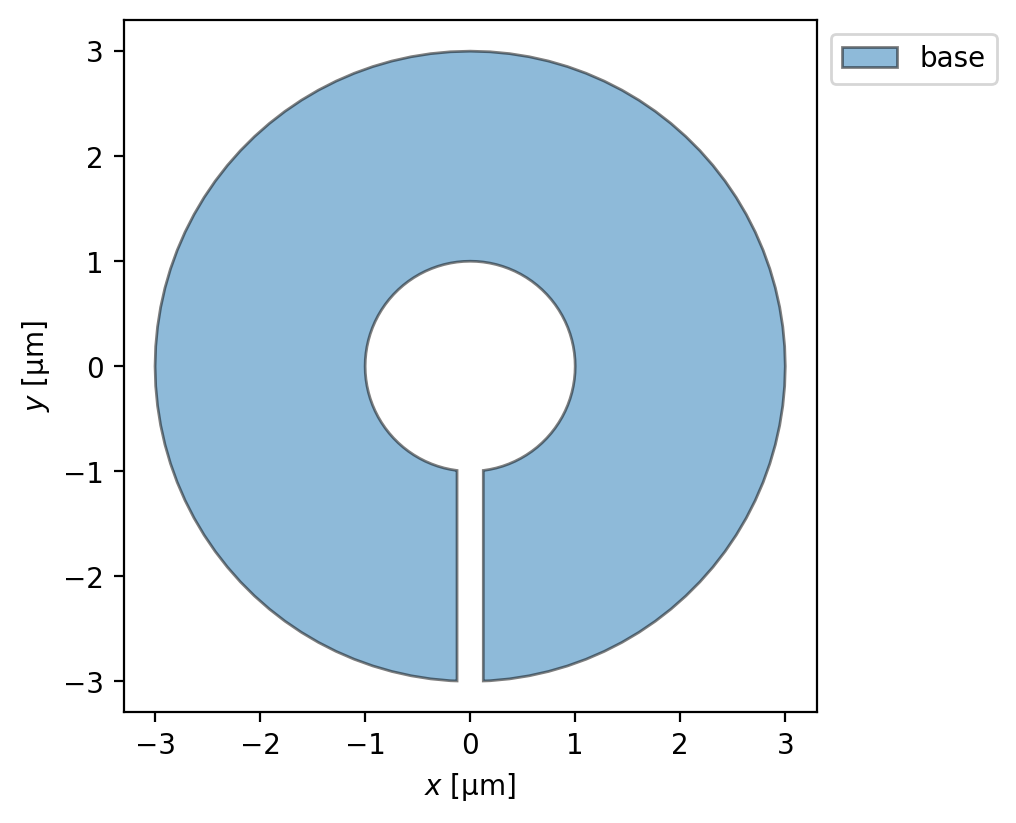

In [6]:
fig, ax = device.draw(legend=True)

### Generate the mesh

In [7]:
device.make_mesh(max_edge_length=0.15, smooth=100)

In [8]:
device.mesh_stats()

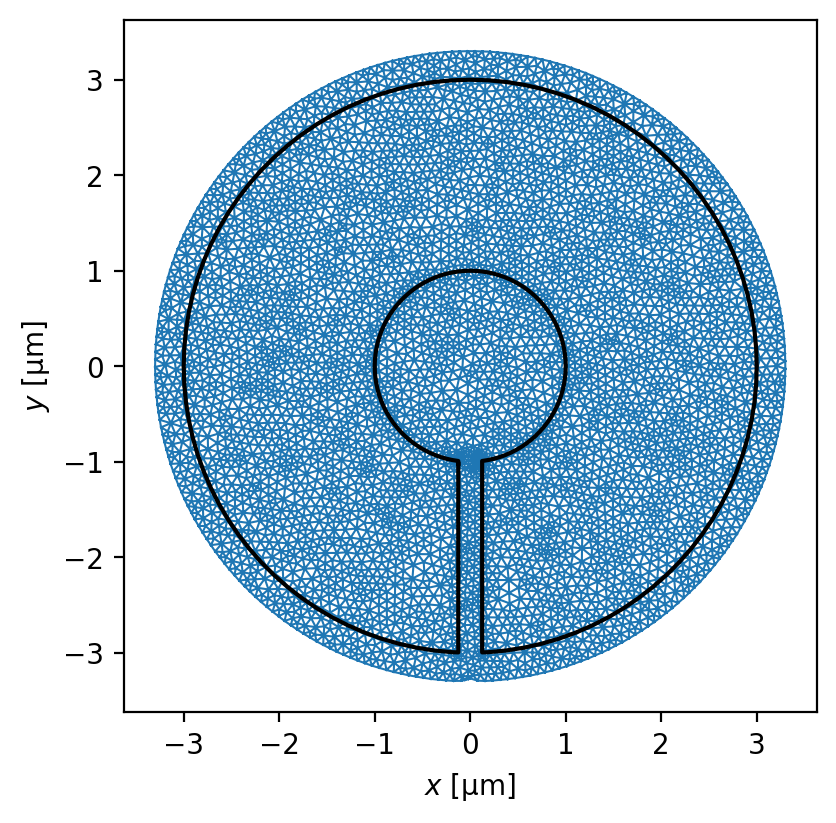

In [9]:
fig, ax = device.plot_mesh(show_sites=False)
_ = device.plot_polygons(ax=ax, color="k")

### Simulate Meissner screening

Here we apply a uniform field field in the $+z$ direction and calculate the ring's magnetic response.

In [10]:
applied_field = sc.sources.ConstantField(1)

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    field_units="uT",
    current_units="uA",
)
assert len(solutions) == 1
solution = solutions[-1]

In [11]:
xs = np.linspace(-3.5, 3.5, 401)

cross_section_coords = [
    # [x-coords, y-coords]
    np.array([xs, 0 * xs]).T,  # horizontal cross-section
    np.array([xs, -2 * np.ones_like(xs)]).T,  # horizontal cross-section
    np.array([0 * xs, xs]).T,  # vertical cross-section
]

#### Visualize the fields

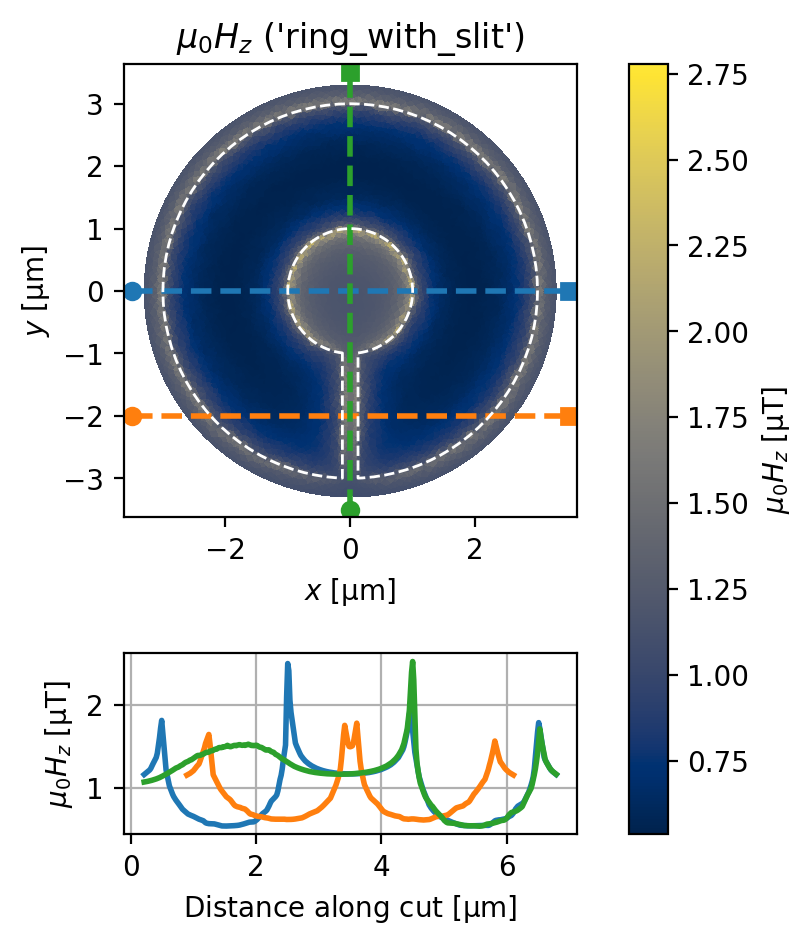

In [12]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords, figsize=(4, 5)
)
for ax in axes:
    _ = device.plot_polygons(ax=ax, color="w", ls="--", lw=1)

#### Visualize the currents

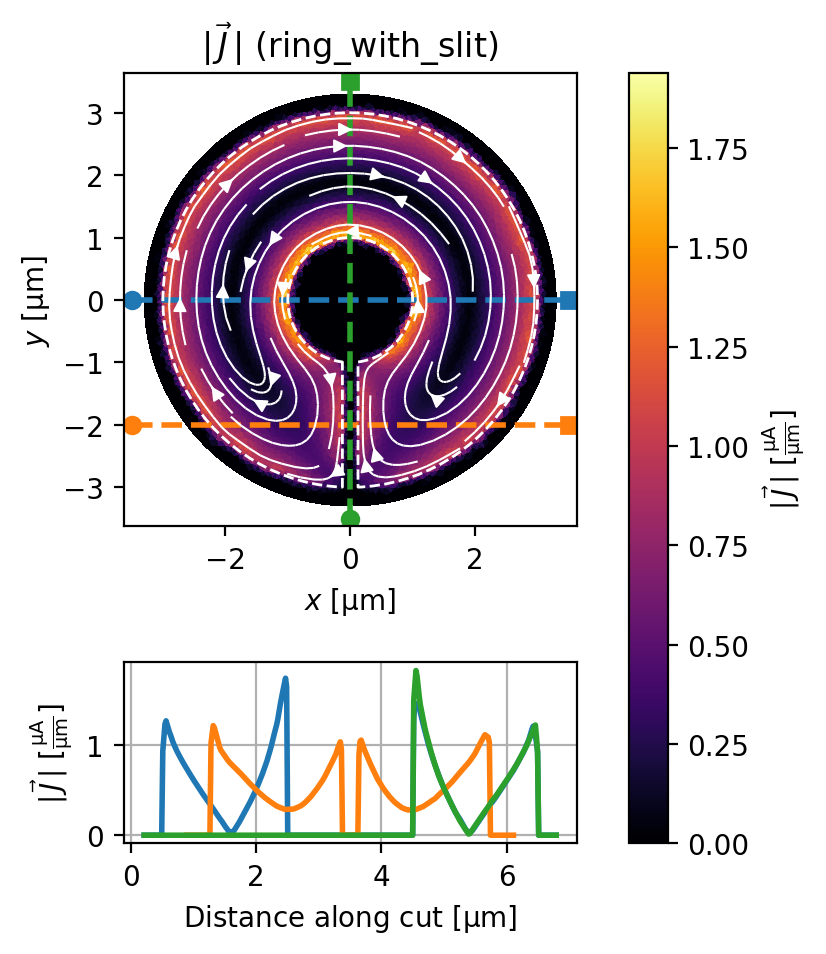

In [13]:
fig, axes = solution.plot_currents(
    cross_section_coords=cross_section_coords,
    figsize=(4, 5),
)
for ax in axes:
    _ = device.plot_polygons(ax=ax, color="w", ls="--", lw=1)

### Simulate trapped vortices

We represent a trapped vortex as an instance of the `superscreen.Vortex` class. Here we assume no applied field.

In [14]:
vortices = [
    sc.Vortex(x=1.5, y=1.5, film="ring_with_slit"),
    sc.Vortex(x=-1.5, y=-1.5, film="ring_with_slit"),
    sc.Vortex(x=0, y=2.5, film="ring_with_slit"),
]

solutions = sc.solve(
    device=device, vortices=vortices, field_units="mT", current_units="mA"
)
assert len(solutions) == 1
solution = solutions[-1]

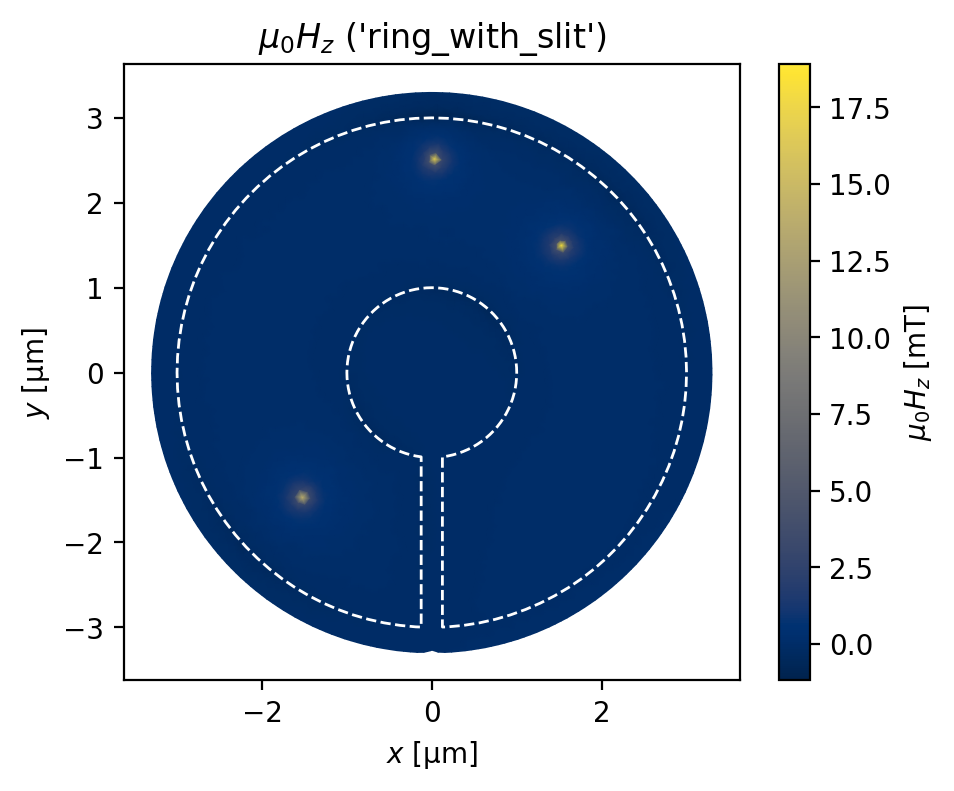

In [15]:
fig, axes = solution.plot_fields(shading="gouraud")
for ax in axes:
    _ = device.plot_polygons(ax=ax, color="w", ls="--", lw=1)

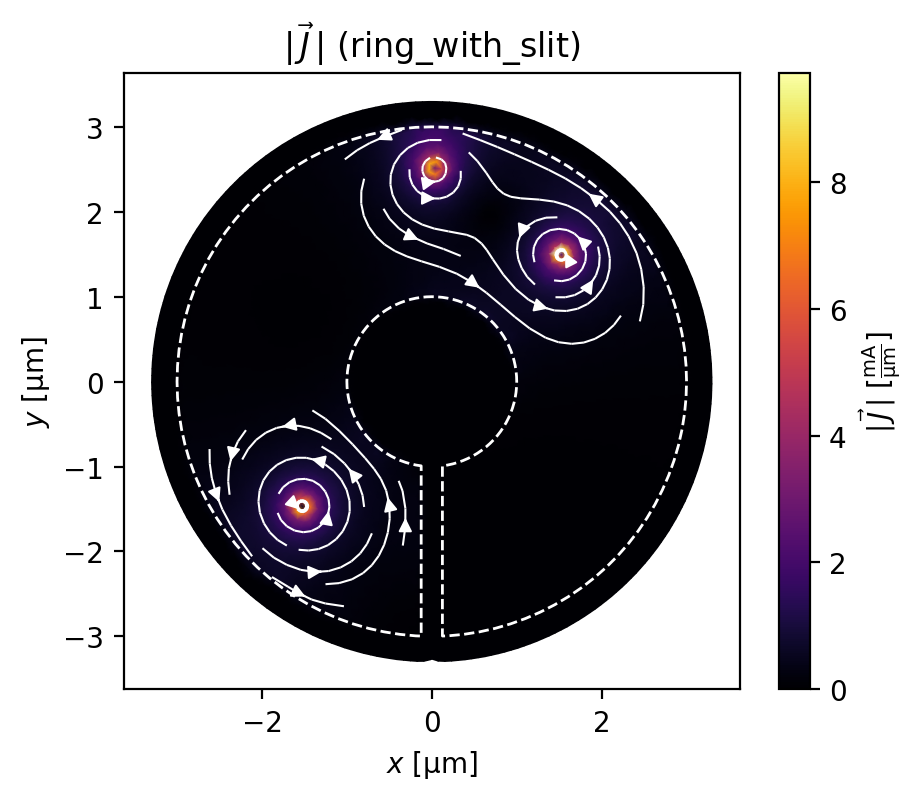

In [16]:
fig, axes = solution.plot_currents(shading="gouraud")
for ax in axes:
    _ = device.plot_polygons(ax=ax, color="w", ls="--", lw=1)

## Superconducting ring without a slit

Let's see what happens if we add a hole to our device (making it a ring or washer).

In [17]:
device = sc.Device(
    "ring",
    layers=[sc.Layer("base", london_lambda=0.100, thickness=0.025, z0=0)],
    films=[sc.Polygon("ring", layer="base", points=ring)],
    holes=[sc.Polygon("hole", layer="base", points=hole)],
    length_units=length_units,
)

In [18]:
device.make_mesh(max_edge_length=0.15, smooth=100)

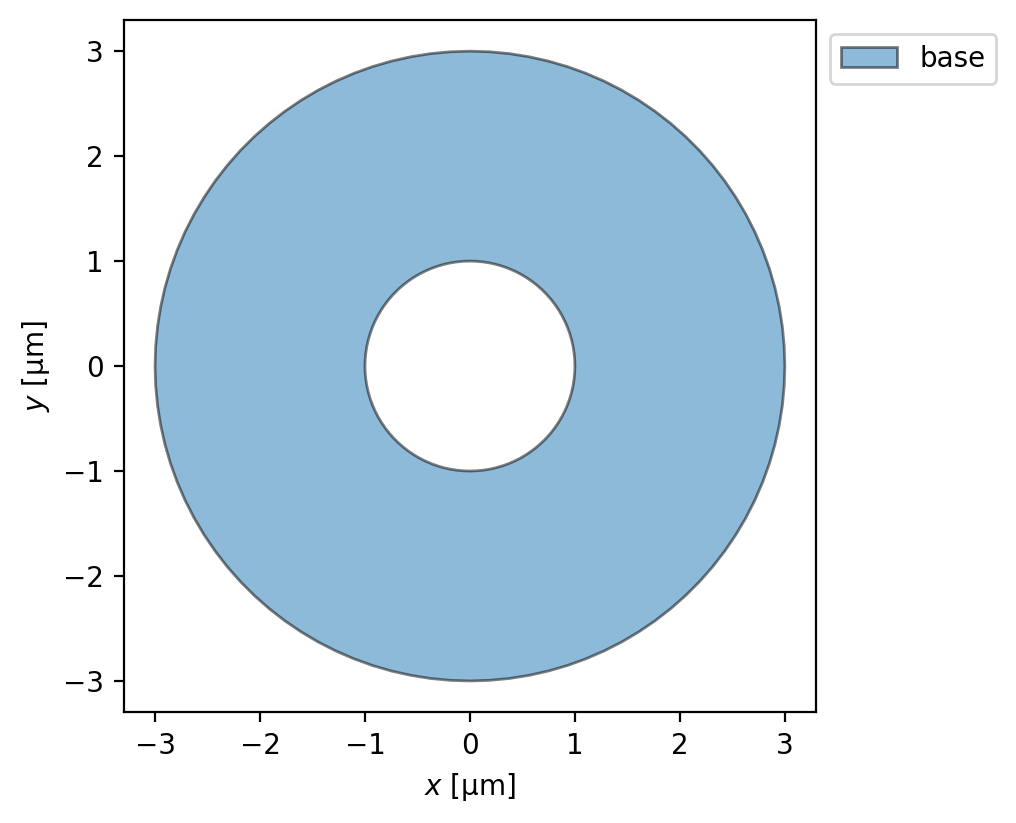

In [19]:
fig, ax = device.draw(legend=True)

### Trapped flux

We can also solve for the field and current distribution from circulating currents associated with flux trapped in the hole.

We assume there is a total current of 1 mA circulating clockwise in the ring (associated with some positive net trapped flux), and that there is otherwise no applied magnetic field. From here we can calculate the current distribution in the ring, the total magnetic field in the plane of the ring, and the flux through the ring.

Note that, although here we are assuming no applied field, we can also solve models with both trapped flux and applied fields.

In [20]:
circulating_currents = {"hole": "1 mA"}

solutions = sc.solve(
    device,
    circulating_currents=circulating_currents,
    field_units="mT",
    current_units="mA",
)
solution = solutions[-1]

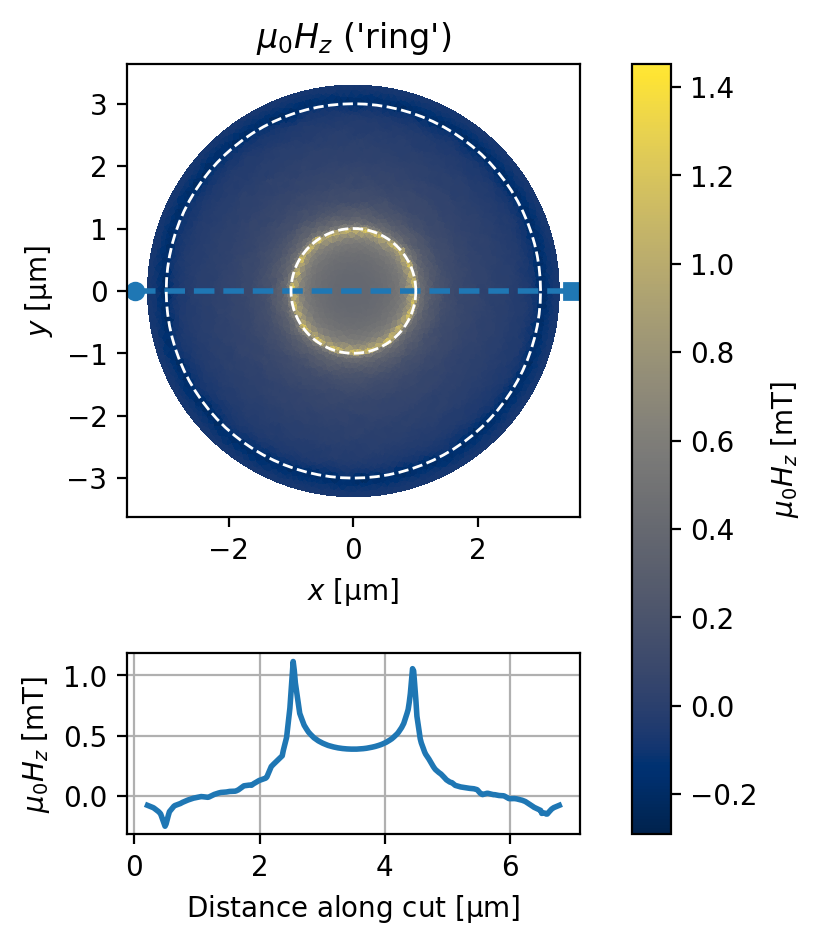

In [21]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords[:1], figsize=(4, 5)
)
for ax in axes:
    _ = device.plot_polygons(ax=ax, color="w", ls="--", lw=1)

### Verify the circulating current by integrating the current density $\vec{J}$

x cut, total current: 0.98654 mA (error = 1.346%)
y cut, total current: 0.99425 mA (error = 0.575%)


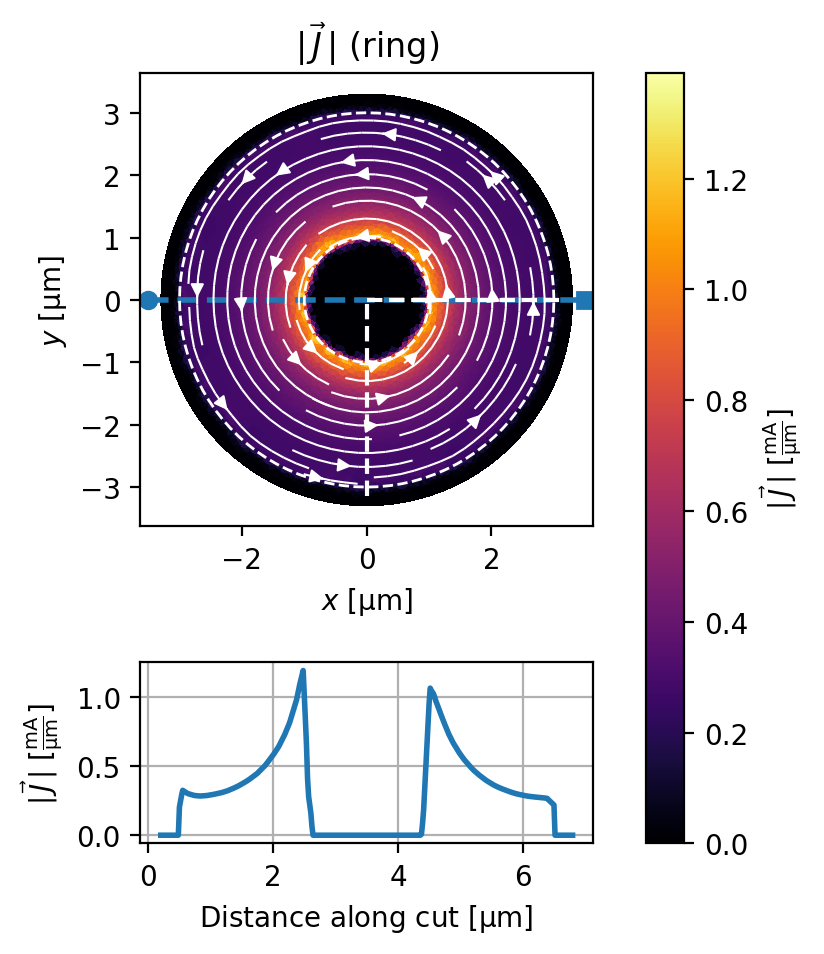

In [22]:
fig, axes = solution.plot_currents(
    units="mA/um",
    cross_section_coords=cross_section_coords[:1],
    figsize=(4, 5),
)
for ax in axes:
    _ = device.plot_polygons(ax=ax, color="w", ls="--", lw=1)

# horizontal cut
xs = np.linspace(0, 3.15, 151)
xcut = np.array([xs, 0 * xs]).T
# vertical cut
ys = np.linspace(-3.15, 0, 101)
ycut = np.array([0 * ys, ys]).T

for i, (cut, label, axis) in enumerate(zip((xcut, ycut), "xy", (1, 0))):
    # Plot the cut coordinates on the current plot
    for ax in axes:
        ax.plot(cut[:, 0], cut[:, 1], "w--")
    # Evaluate the current density at the cut coordinates
    j_interp = solution.interp_current_density(cut, film="ring", units="mA / um", with_units=False)
    # Integrate the approriate component of the current density
    # along the cut to get the total circulating current.
    I_tot = np.trapz(j_interp[:, axis], x=cut[:, i])
    I_target = 1  # mA
    print(
        f"{label} cut, total current: {I_tot:.5f} mA "
        f"(error = {100 * abs((I_tot - I_target) / I_target):.3f}%)"
    )

### Calculate the ring's fluxoid and self-inductance

The self-inductance of a superconducting loop with a hole $h$ is given by

$$
L = \frac{\Phi_h^f}{I_h},
$$

where $I_h$ is the current circulating around the hole and $\Phi_h^f$ is the fluxoid for a path enclosing the hole. The fluxoid $\Phi^f_S$ for a 2D region $S$ with 1D boundary $\partial S$ is given by the sum of flux through $S$ and the line integral of sheet current around $\partial S$:

$$
    \Phi^f_S = \underbrace{\int_S\mu_0H_z(\vec{r})\,\mathrm{d}^2r}_\text{flux part} + \underbrace{\oint_{\partial S}\mu_0\Lambda\vec{J}(\vec{r})\cdot\mathrm{d}\vec{r}}_\text{supercurrent part}.
$$

The method `Solution.polygon_fluxoid()` calculates the fluxoid for an arbitrary closed region in a `Device`, and the method `Solution.hole_fluxoid()` calculates the fluxoid for a given hole in a `Device` (automatically generating an appropriate integration region $S$ if needed).

For a device with $N$ holes, there are $N^2$ mutual inductances between them. This mutual inductance matrix is given by:

$$
M_{ij}=\frac{\Phi_i^f}{I_j},
$$

where $\Phi_i^f$ is the fluxoid for a region enclosing hole $i$ and $I_j$ is the current circulating around hole $j$. Note that the mutual inductance matrix is symmetric: $M_{ij}=M_{ji}$. The diagonals of the mutual inductance matrix are the hole self-inductances: $M_{ii} = L_i$, the self-inductance of hole $i$.

The above process of modeling a circulating current for each hole, calculating the fluxoid, and extracting the inductance is automated in the method `Device.mutual_inductance_matrix()`. In this case, for our device with a single hole, the mutual inductance matrix will be a $1\times1$ matrix containing only the self-inductance $L$.

Calculate the fluxoid $\Phi^f$:

In [23]:
region = circle(2)
fluxoid = solution.polygon_fluxoid(region, film="ring")
print(fluxoid)
print(f"The total fluxoid is: {sum(fluxoid):~.3fP}")

Fluxoid(flux_part=<Quantity(1.67298778, 'magnetic_flux_quantum')>, supercurrent_part=<Quantity(1.1176957, 'magnetic_flux_quantum')>)
The total fluxoid is: 2.791 Φ_0


In [24]:
hole_name = list(device.holes)[0]
fluxoid = solution.hole_fluxoid(hole_name)
print(fluxoid)
print(f"The total fluxoid is: {sum(fluxoid):~.3fP}")

Fluxoid(flux_part=<Quantity(1.67298778, 'magnetic_flux_quantum')>, supercurrent_part=<Quantity(1.1176957, 'magnetic_flux_quantum')>)
The total fluxoid is: 2.791 Φ_0


Calculcate self-inductance $L=\Phi^f / I_\mathrm{circ}$:

In [25]:
I_circ = solution.circulating_currents["hole"] * device.ureg(solution.current_units)
L = (sum(fluxoid) / I_circ).to("Phi_0 / A")
print(f"The ring's self-inductance is {L:.3f~P} = {L.to('pH'):~.3fP}.")

The ring's self-inductance is 2790.683 Φ_0/A = 5.771 pH.


Calculcate self-inductance using `Device.mutual_inductance_matrix()`:

In [26]:
M = device.mutual_inductance_matrix(units="Phi_0 / A")
print(f"Mutual inductance matrix shape:", M.shape)
L = M[0, 0]
print(f"The ring's self-inductance is {L:.3f~P} = {L.to('pH'):~.3fP}.")

Mutual inductance matrix shape: (1, 1)
The ring's self-inductance is 2790.683 Φ_0/A = 5.771 pH.


### Solve for a specific fluxoid state: $\Phi^f=n\Phi_0$

Current and field distributions for a given fluxoid state $\Phi^f=n\Phi_0$, where $\Phi_0$ is the superconducting flux quantum, can be modeled by adjusting the circulating current $I_\mathrm{circ}$ to realize the desired fluxoid value. This calculation is performed by the function `superscreen.find_fluxoid_solution()`.

Here we solve for the current distribution in the ring for the $n=0$ fluxoid state (i.e. Meissner state), which can be achieved by cooling the ring through its superconducting transition with no applied field. If a small field is then applied, it is screened by the ring such that the fluxoid remains zero.

In [27]:
# n = 0 fluxoid state, apply a field of 1 mT
solution = sc.find_fluxoid_solution(
    device,
    fluxoids=dict(hole=0),
    applied_field=sc.sources.ConstantField(1),
    field_units="mT",
    current_units="mA",
)
I_circ = solution.circulating_currents["hole"]
fluxoid = sum(solution.hole_fluxoid("hole")).to("Phi_0").magnitude
print(f"Total circulating current: {I_circ:.3f} mA.")
print(f"Total fluxoid: {fluxoid:.6f} Phi_0.")

Total circulating current: -1.815 mA.
Total fluxoid: -0.000004 Phi_0.


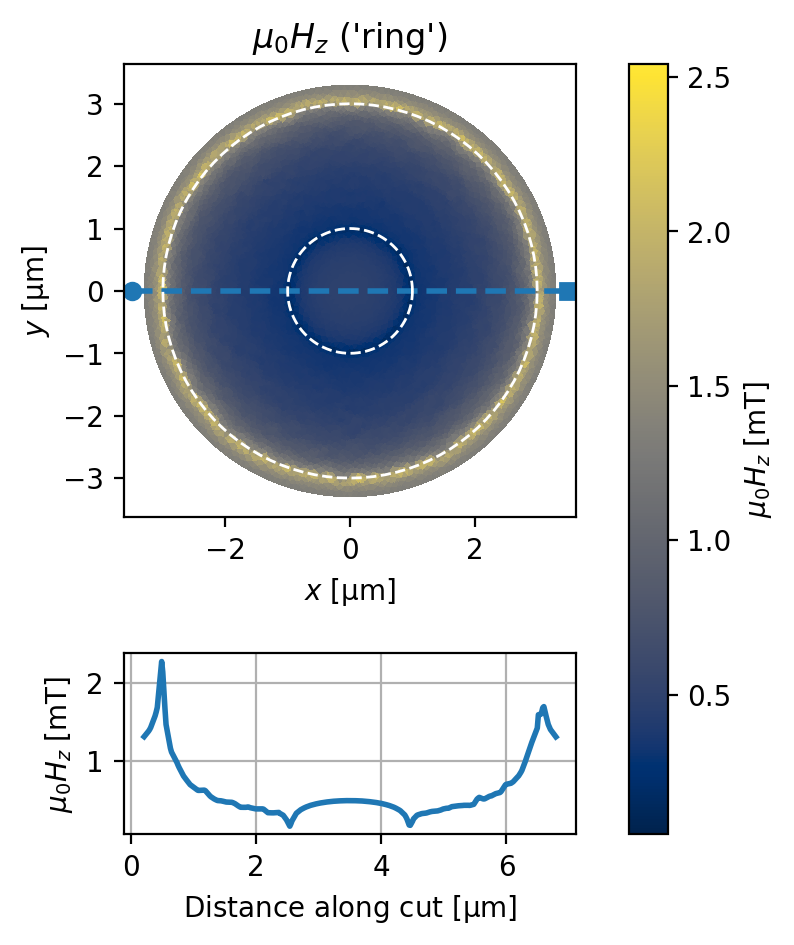

In [28]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords[:1], figsize=(4, 5)
)
for ax in axes:
    _ = device.plot_polygons(ax=ax, color="w", ls="--", lw=1)

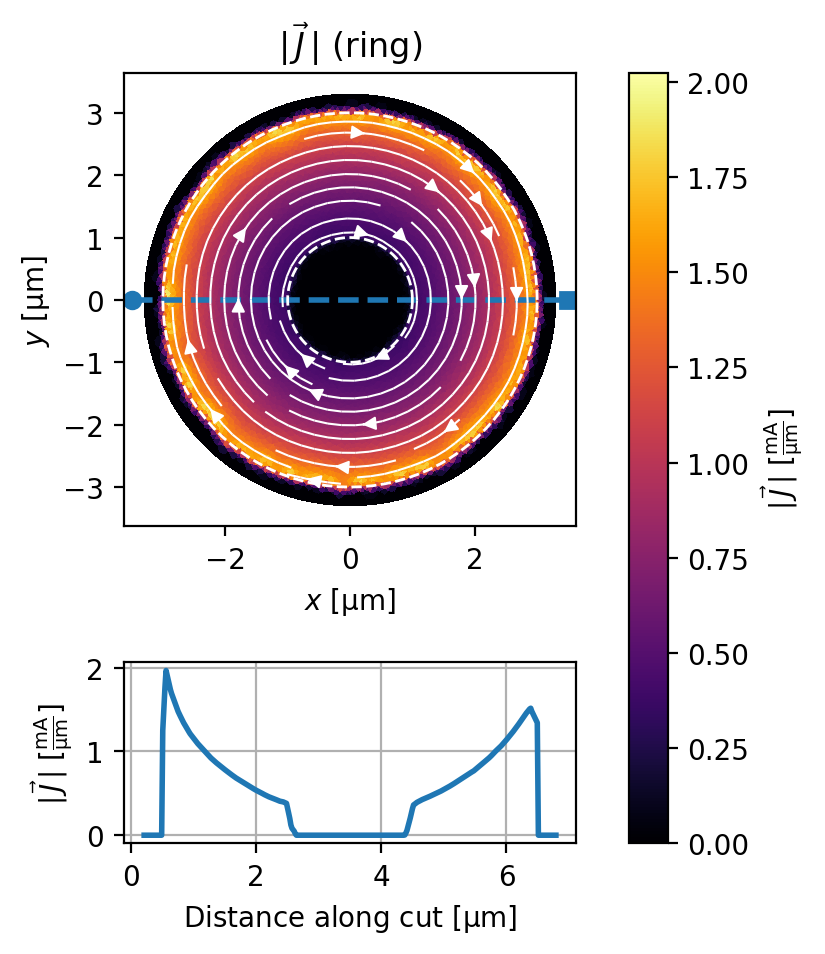

In [29]:
fig, axes = solution.plot_currents(
    cross_section_coords=cross_section_coords[:1], figsize=(4, 5)
)
for ax in axes:
    _ = device.plot_polygons(ax=ax, color="w", ls="--", lw=1)

Similarly, we can solve for a non-zero fluxoid state, in this case with no applied field. A non-zero fluxoid state can be realized by cooling a ring through its superconducting transition with an applied field.

In [30]:
# n = 1 fluxoid state, apply a field of 0 mT
solution = sc.find_fluxoid_solution(
    device,
    fluxoids=dict(hole=1),
    applied_field=sc.sources.ConstantField(0),
    field_units="mT",
    current_units="mA",
)
I_circ = solution.circulating_currents["hole"]
fluxoid = sum(solution.hole_fluxoid("hole")).to("Phi_0").magnitude
print(f"Total circulating current: {I_circ:.3f} mA.")
print(f"Total fluxoid: {fluxoid:.6f} Phi_0.")

Total circulating current: 0.358 mA.
Total fluxoid: 1.000000 Phi_0.


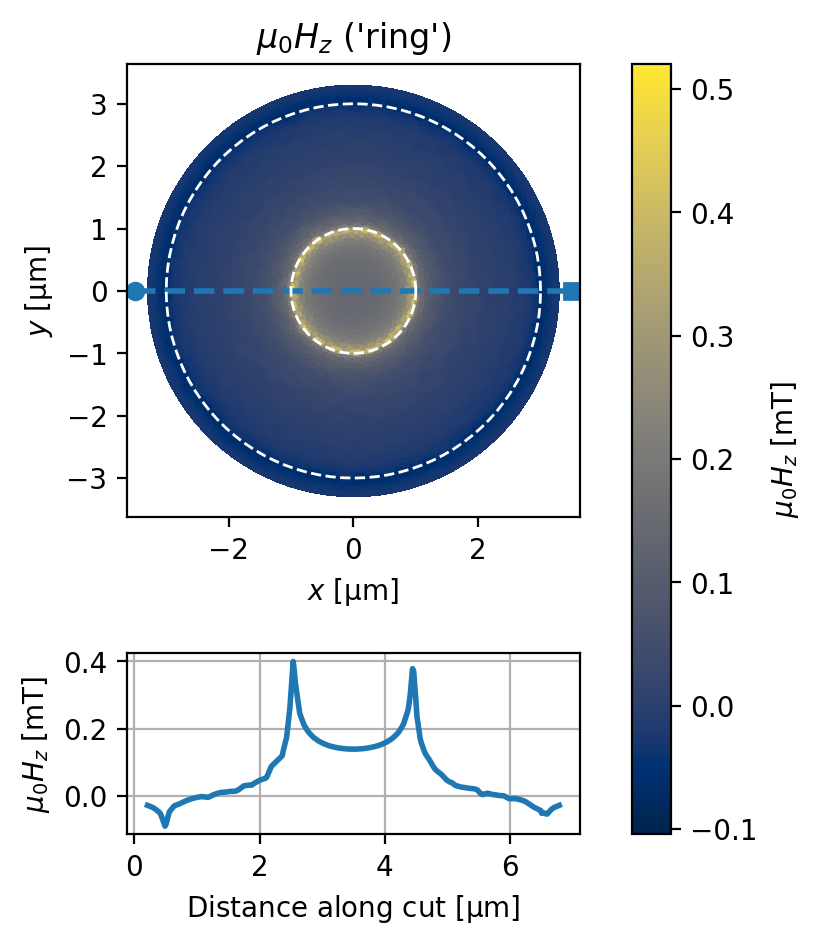

In [31]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords[:1], figsize=(4, 5)
)
for ax in axes:
    _ = device.plot_polygons(ax=ax, color="w", ls="--", lw=1)

## Film with multiple holes

Here we simulate a device with fewer symmetries than the ring, namely a rectangular film with two off-center rectangular holes.

In [32]:
length_units = "um"

layers = [sc.Layer("base", Lambda=0.1, z0=0)]

films = [sc.Polygon("film", layer="base", points=box(8, 4))]

holes = [
    sc.Polygon("hole0", layer="base", points=box(5, 1, center=(0.5, -0.25))).buffer(0),
    sc.Polygon("hole1", layer="base", points=box(1, 2.5, center=(-3, 0.25))).buffer(0),
]

device = sc.Device(
    "rect",
    layers=layers,
    films=films,
    holes=holes,
    length_units=length_units,
)

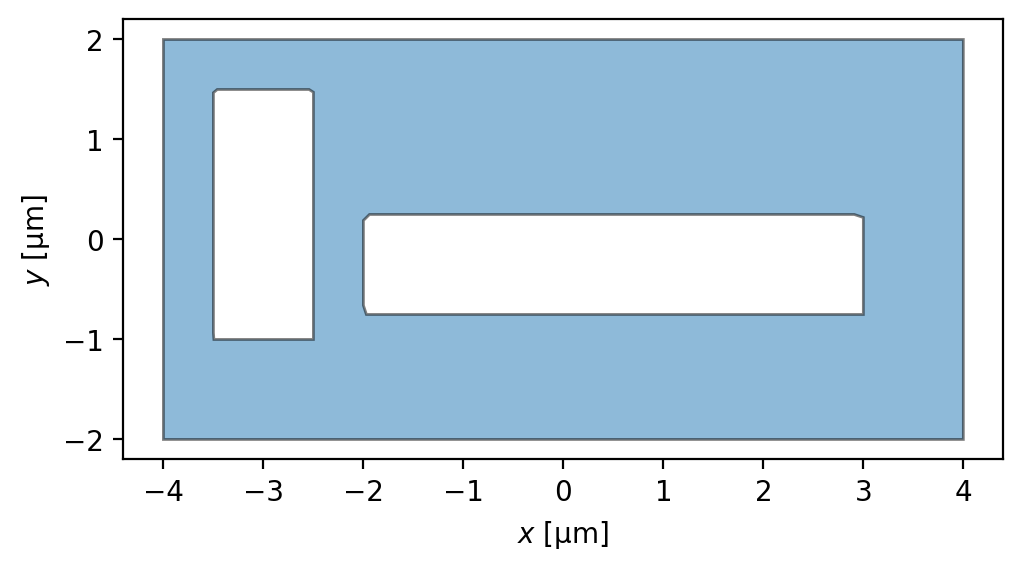

In [33]:
fig, ax = device.draw()

In [34]:
device.make_mesh(max_edge_length=0.15)

In [35]:
device.mesh_stats()

### Full mutual inductance matrix

In [36]:
M = device.mutual_inductance_matrix(units="pH")
print(f"Mutual inductance matrix shape:", M.shape)
display(M)

Mutual inductance matrix shape: (2, 2)


array([[ 6.56992598, -1.00086802],
       [-1.00461471,  4.99138424]]) <Unit('picohenry')>

As promised, the mutual inductance matrix is approximately symmetric:

In [37]:
asymmetry = float(np.abs((M[0, 1] - M[1, 0]) / min(M[0, 1], M[1, 0])))
print(f"Mutual inductance matrix fractional asymmetry: {100 * asymmetry:.3f}%")

Mutual inductance matrix fractional asymmetry: 0.373%


### Model both holes in the $n=0$ fluxoid state

In [38]:
# n = 0 fluxoid state, apply a field of 1 mT
solution = sc.find_fluxoid_solution(
    device,
    fluxoids=dict(hole0=0, hole1=0),
    applied_field=sc.sources.ConstantField(1),
    field_units="mT",
    current_units="mA",
)

In [39]:
I_circ = solution.circulating_currents
fluxoids = [
    sum(solution.hole_fluxoid(hole)).to("Phi_0").magnitude
    for hole in ("hole0", "hole1")
]
print(f"Total circulating current: {I_circ} mA.")
print(f"Total fluxoid: {fluxoids} Phi_0.")

Total circulating current: {'hole0': -2.1034162459767836, 'hole1': -1.4513395769268758} mA.
Total fluxoid: [1.100891965888362e-05, 2.8117781281422616e-05] Phi_0.


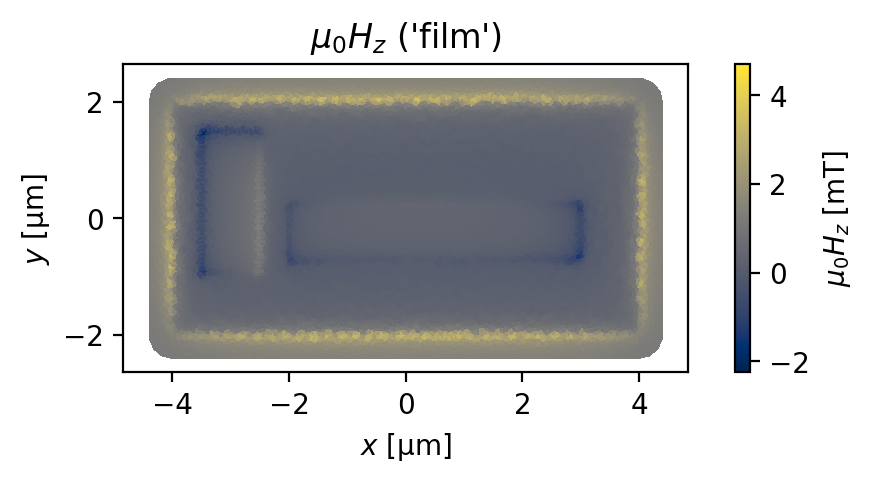

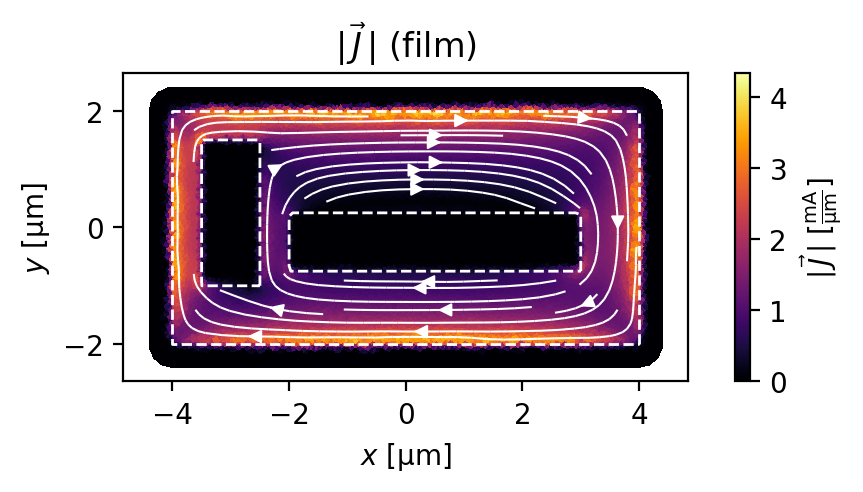

In [40]:
fig, axes = solution.plot_fields(figsize=(6, 2))
fig, axes = solution.plot_currents(figsize=(6, 2))
for ax in axes:
    _ = device.plot_polygons(ax=ax, color="w", ls="--", lw=1)

## Devices with multiple films

In this example we model a an on-chip flux bias line (in layer ``W0``), which is partially covered by a shield in another layer (``W1``). We use ``SuperScreen`` to calculate the mutual inductance between the bias line and a pickup loop which also lies in ``W0``. Both layers are assumed to have a London penetration depth of 100 nm and thickness of 50 nm, and the vertical spacing between the layers is 250 nm.

In [41]:
# Wiring layers
W0 = sc.Layer("W0", london_lambda=0.1, thickness=0.05, z0=0.0)
W1 = sc.Layer("W1", london_lambda=0.1, thickness=0.05, z0=0.25)

# Pickup loop geometry
pickup_loop = sc.Polygon("pickup_loop", layer="W0", points=box(5, 10))
pickup_loop_center = sc.Polygon("pickup_loop_center", layer="W0", points=box(3, 8))

# Bias line and shield
bias_line = sc.Polygon(
    "bias_line", layer="W0", points=box(10, 5)
).difference(box(10, 4, center=(0.5, 0))).resample(501).translate(dx=8)
bias_line_shield = sc.Polygon(
    "bias_line_shield", layer="W1", points=box(9, 6)
).translate(dx=10)

# Transport terminals
source = sc.Polygon("source", points=box(0.1, 1)).translate(dx=13, dy=2.25)
drain = source.scale(yfact=-1).set_name("drain")

device = sc.Device(
    "bias_loop",
    layers=[W0, W1],
    films=[bias_line, bias_line_shield, pickup_loop],
    holes=[pickup_loop_center],
    terminals={"bias_line": [source, drain]},
    length_units="um",
)

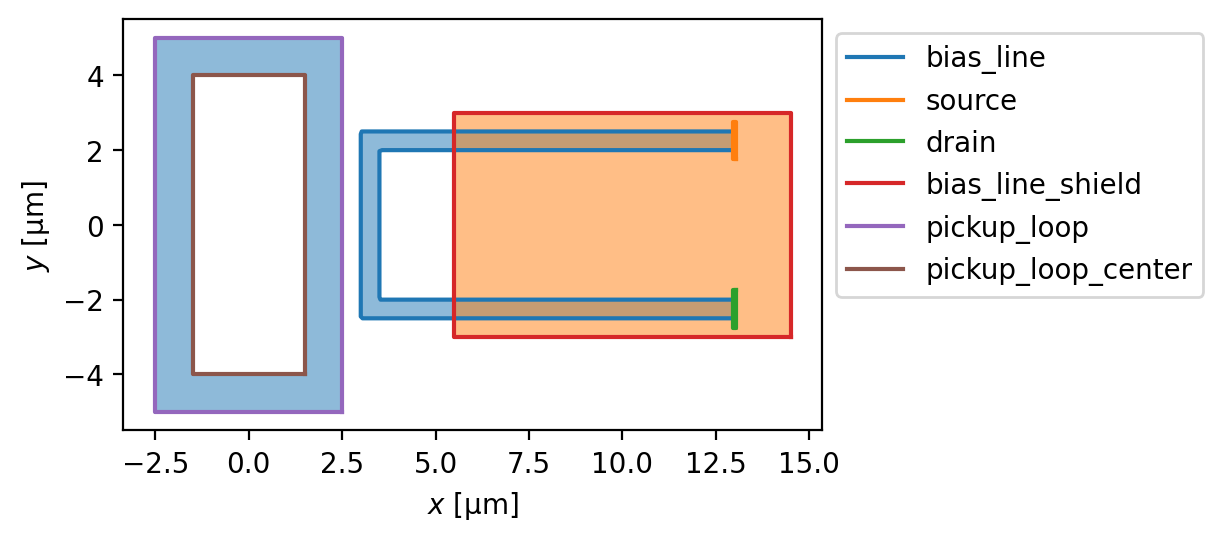

In [42]:
fig, ax = device.draw(figsize=(6, 4))
_ = device.plot_polygons(ax=ax, legend=True)

In [43]:
device.make_mesh(max_edge_length=0.25)

In [44]:
device.mesh_stats()

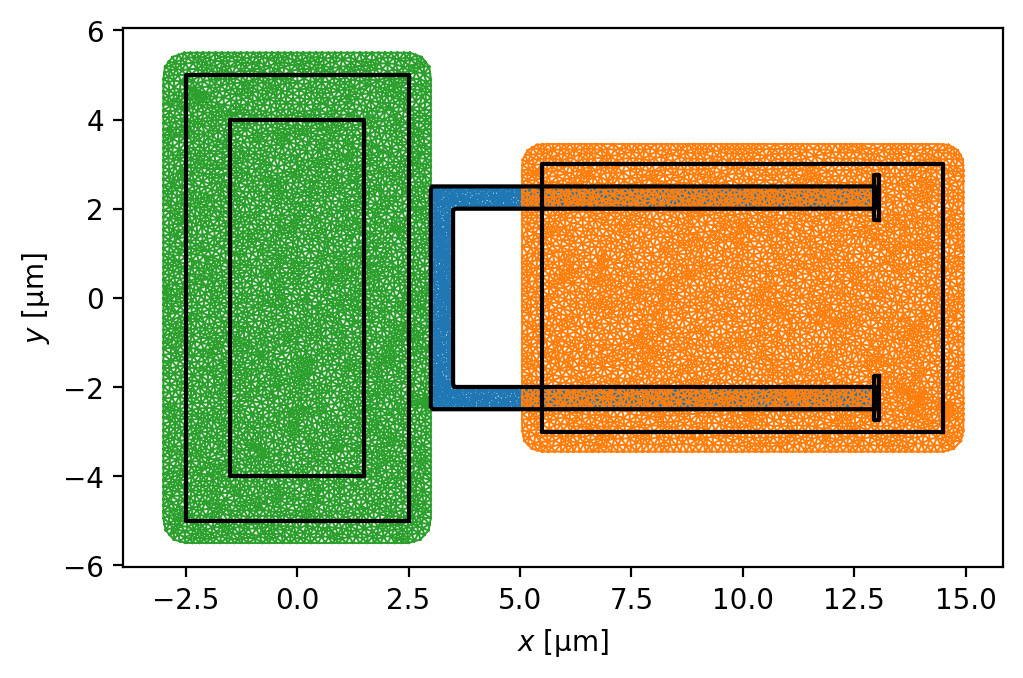

In [45]:
fig, ax = device.plot_mesh()
_ = device.plot_polygons(ax=ax, color="k")

Solve the model with 1 mA flowing through the bias line.

In [46]:
I_bias = "1 mA"
solutions = sc.solve(
    device,
    terminal_currents={"bias_line": {"source": I_bias, "drain": f"-{I_bias}"}},
    iterations=10,
)

Solver iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s]


Plot the sheet current density in each film.

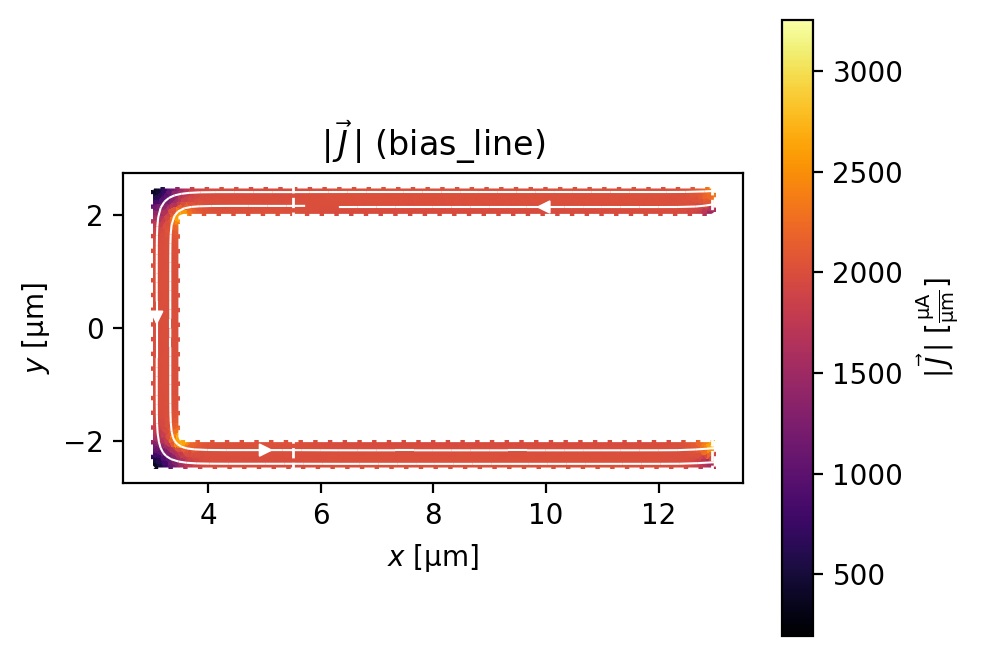

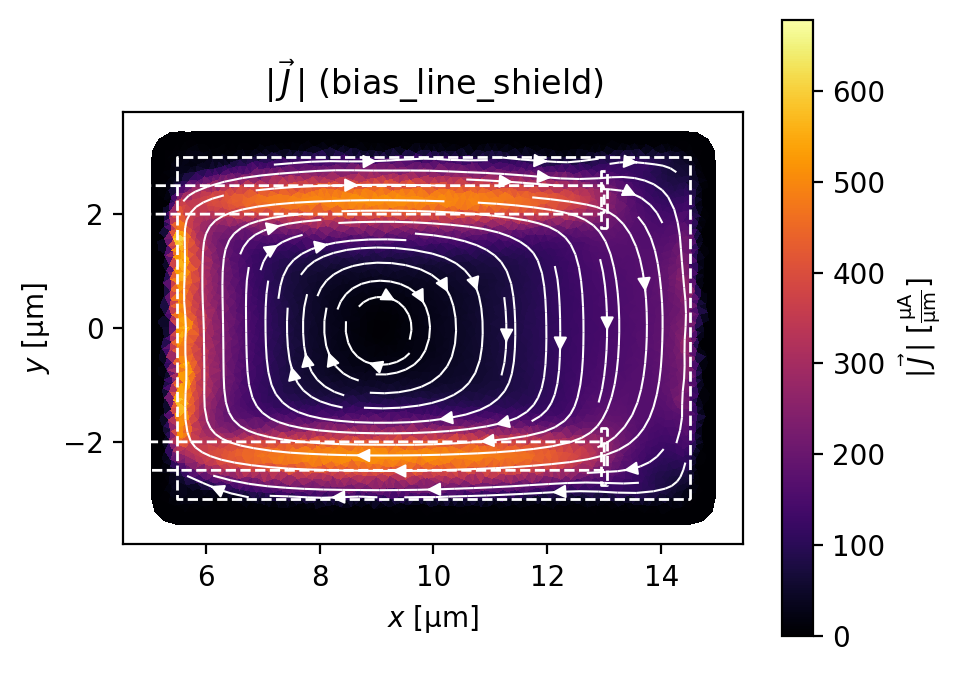

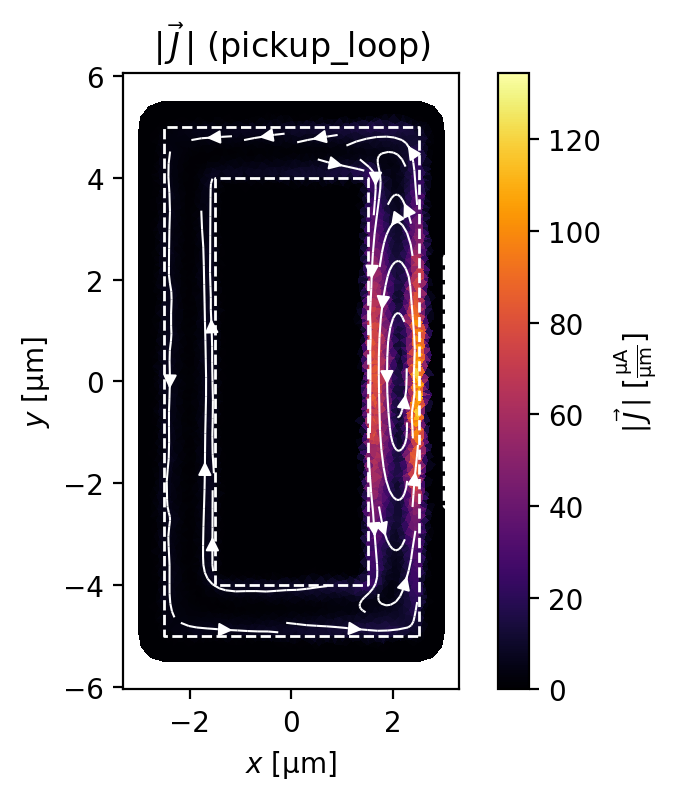

In [47]:
for film in device.films:
    fig, axes = solutions[-1].plot_currents(films=[film])
    _ = device.plot_polygons(ax=axes[0], color="w", ls="--", lw=1)

Evaluate the field at a plane 500 nm above the ``W0`` layer and 250 nm above the ``W1`` layer. The effect of the shield is clearly visible.

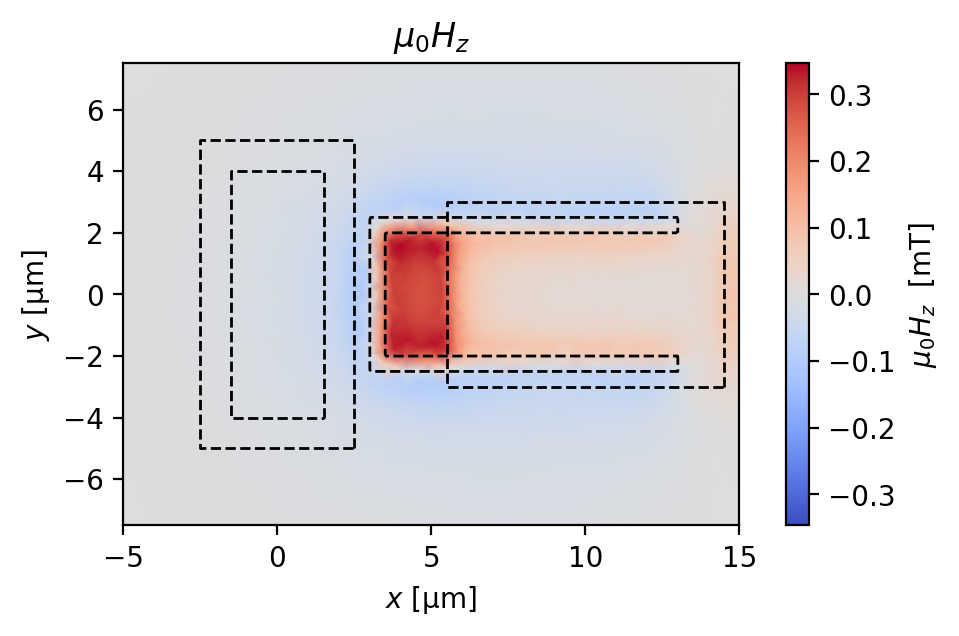

In [48]:
# Generate a mesh of points at which to evaluate the field from the films.
eval_region = sc.Polygon(points=box(20, 15, center=(5, 0)))
eval_mesh = eval_region.make_mesh(min_points=2000)

fig, ax = solutions[-1].plot_field_at_positions(
    eval_mesh,
    zs=0.5,
    figsize=(6, 3),
    symmetric_color_scale=True,
    cmap="coolwarm",
)
for film in device.films.values():
    film.plot(ax=ax, color="k", ls="--", lw=1)
for hole in device.holes.values():
    hole.plot(ax=ax, color="k", ls="--", lw=1)

Evaluate and plot the mutual inductance between the bias line and the loop as a function of the solver iteration. The solution converges very quickly to a value around -0.7 pH.

Mutual inductance = -0.7139 pH


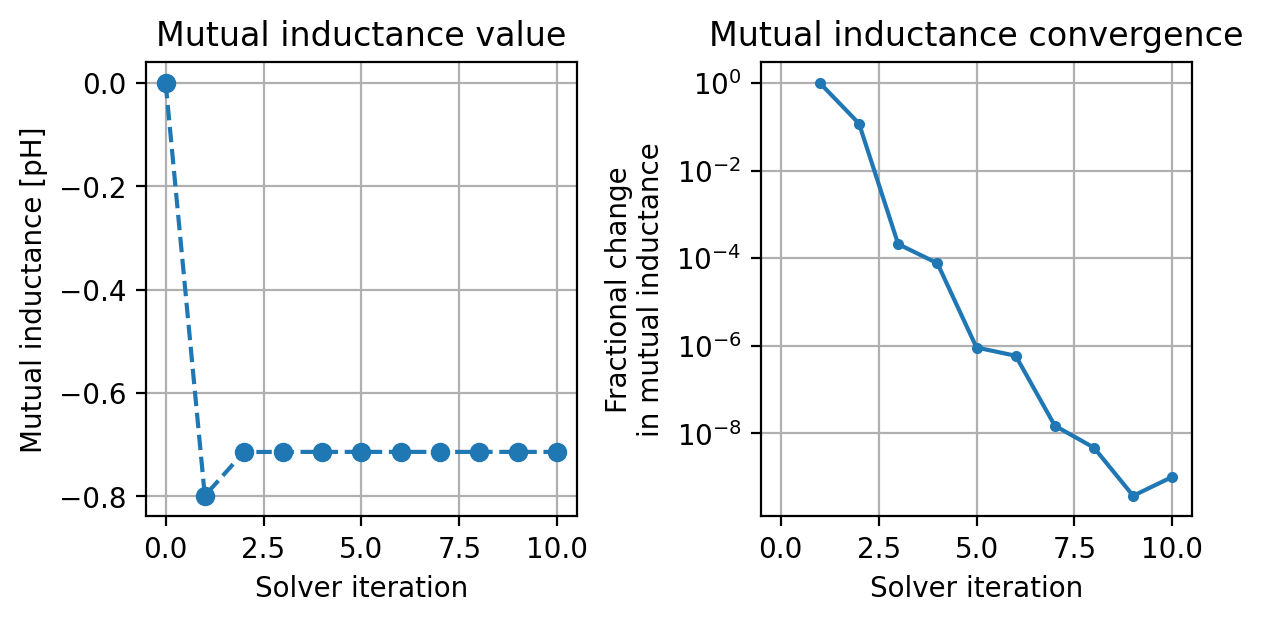

In [49]:
mutual_inductances = []
for solution in solutions:
    fluxoid = sum(solution.hole_fluxoid("pickup_loop_center"))
    mutual_inductance = fluxoid / sc.ureg(I_bias)
    mutual_inductances.append(mutual_inductance.to("pH").magnitude)
    
print(f"Mutual inductance = {mutual_inductances[-1]:.4f} pH")

fig, (ax, bx) = plt.subplots(1, 2, sharex=True, figsize=(6, 3), constrained_layout=True)
ax.plot(range(len(mutual_inductances)), mutual_inductances, "o--")
ax.grid(True)
ax.set_title("Mutual inductance value")
ax.set_xlabel("Solver iteration")
ax.set_ylabel("Mutual inductance [pH]")

diff = np.diff(mutual_inductances)
bx.plot(range(1, len(mutual_inductances)), np.abs(diff / mutual_inductances[1:]), ".-")
bx.set_yscale("log")
bx.grid(True)
bx.set_title("Mutual inductance convergence")
bx.set_xlabel("Solver iteration")
_ = bx.set_ylabel("Fractional change\nin mutual inductance")